In [3]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
from pylab import rcParams
mpl.rcParams.update({'font.size': 22})

%matplotlib inline
import warnings

import statsmodels.api as sm
from patsy import dmatrices

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics

rcParams['figure.figsize'] = 15,10

# Import & Data Cleaning

In [4]:
# #import raw data
# births_raw = pd.read_csv('US_births(2018).csv')
# births = births_raw

# ###convert marital status with strings of '1' and '2' to clean ints
# births['DMAR'] = pd.to_numeric(births['DMAR'].replace(' ', np.nan))
# # births.dropna(inplace=True)

# ##create dummy variable for all codes of c-sections
# births['C_SECTION'] = 0
# csec = [3,4,6]
# nat = [1,2,5]
# unknown = [9]
# c_mask = births['RDMETH_REC'].isin(csec)
# births['C_SECTION'][c_mask] = 1

# unknown_mask = births['RDMETH_REC']==9
# births[unknown_mask]['C_SECTION']==-1

# known_births = births[-unknown_mask]

In [6]:
known_births = pd.read_csv('known_births.csv')

In [7]:
###prior
display(len(known_births))
known_births['C_SECTION'].sum()/known_births['C_SECTION'].count()

3799906

0.318789991120833

# Data Exploration and Visualization with 1 Variables

In [8]:
#relabel unknown BMI as NaN
known_births['BMI'][known_births['BMI'] == 99.9] = np.nan
known_births['BMI'].count()

C:\Users\Rukh\AppData\Local\Temp\ipykernel_24864\1557229064.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  known_births['BMI'][known_births['BMI'] == 99.9] = np.nan


3714370

In [9]:
###create a table of mean value at each BMI (proportion of women at each BMI that get a C-section)
bmi_csec = pd.crosstab(known_births['BMI'], known_births['C_SECTION'])
bmi_csec['percent']= bmi_csec[1]/(bmi_csec[0]+bmi_csec[1])
bmi_csec.iloc[:10]

C_SECTION,0,1,percent
BMI,,,
13.0,6,6,0.500000
13.1,22,3,0.120000
13.2,29,8,0.216216
13.3,31,16,0.340426
13.4,29,10,0.256410
13.5,37,7,0.159091
13.6,46,9,0.163636
13.7,74,28,0.274510
13.8,30,13,0.302326


In [10]:
#create columns that show how p(bmi|method)/p(method)
bmi_csec['pct0'] = bmi_csec[0]*100/bmi_csec[0].sum()
bmi_csec['pct1'] = bmi_csec[1]*100/bmi_csec[1].sum()
bmi_csec.sort_values(by='pct1', ascending=False).iloc[:5]

C_SECTION,0,1,percent,pct0,pct1
BMI,,,,,
26.6,47323,20946,0.306816,1.869774,1.769950
28.3,39350,20441,0.341874,1.554754,1.727278
27.4,29923,14359,0.324263,1.182285,1.213345
23.0,35491,13691,0.278374,1.402281,1.156898
25.8,31896,12464,0.280974,1.260240,1.053216


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '% of Births via C-Section')

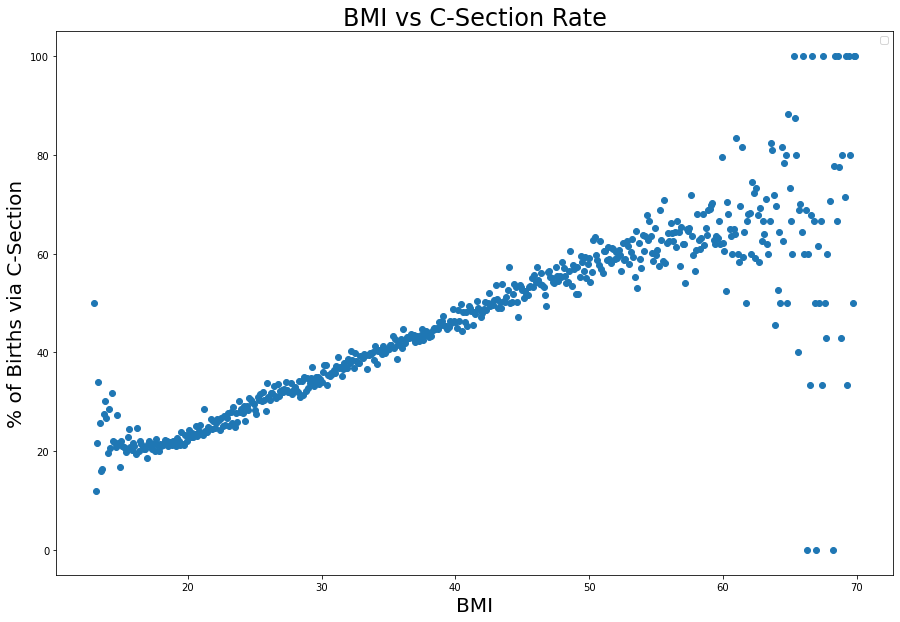

In [11]:
###plot the relationship of BMI and the proportion of women that get C-sections
vis = bmi_csec.reset_index()
plt.scatter(vis['BMI'],vis['percent']*100)
plt.title('BMI vs C-Section Rate', fontsize=24)
# plt.plot(vis2['BMI'], lm_pred, color='red', linewidth=5, label='Regression')
plt.legend(loc='best')
plt.xlabel('BMI', fontsize=20)
plt.ylabel('% of Births via C-Section', fontsize=20)

In [12]:
plt.savefig('LMBMIVRATE')

<Figure size 1080x720 with 0 Axes>

## There is a very clear linear relationship between BMI and the % likelihood of getting a C-Section. However, this will not serve well for classification.

<AxesSubplot:xlabel='BMI'>

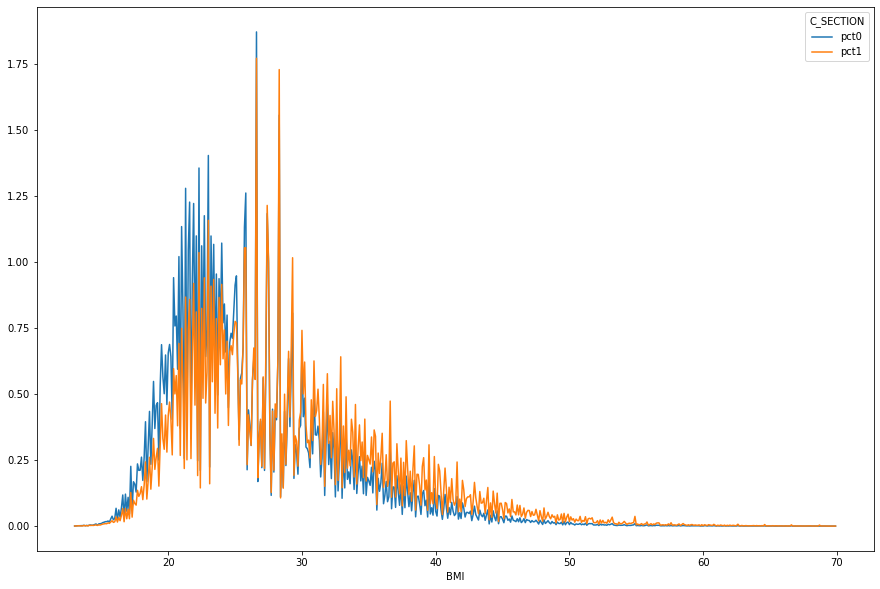

In [13]:
#Graphing each BMI's relative composition of delivery method.
bmi_csec[['pct0','pct1']].plot()

## Lower BMIs are more likely to be natural births. Higher BMIs are more likely to be C-Sections. But the volumes at each section total up to about the same (high BMI long-tail).
### (The blue line starts out above the orange line, and then the orange line crosses over.)

# Logistic Regression Classification - 1 Variable with BMI

In [14]:
#set up matrices for regression with 1 variable
formula = 'C_SECTION ~ 0 + BMI'
y, X = dmatrices(formula, known_births, return_type='dataframe')

In [15]:
len(X)

3714370

In [16]:
y.tail()

,C_SECTION
3799900,1.0
3799901,1.0
3799902,0.0
3799903,0.0
3799905,0.0


In [17]:
##assign matrices to ML model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [18]:
#set up logistic model
model = LogisticRegression()
result = model.fit(X_train, y_train)

c:\Users\Rukh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [19]:
#test logistic model on holdout set
y_pred = model.predict(X_test)
print('Acc {}'.format(metrics.accuracy_score(y_test, y_pred)))
print('Precision {}'.format(metrics.precision_score(y_test, y_pred)))
print('Recall {}'.format(metrics.recall_score(y_test, y_pred)))
print('F-Score {}'.format(metrics.f1_score(y_test, y_pred)))

Acc 0.6849227908546178
Precision 0.5441238285982741
Recall 0.062047633951102875
F-Score 0.11139289203403643


In [20]:
#create a confusion matrix
cm1 = metrics.confusion_matrix(y_test, y_pred)
print(cm1)
sensitivity = cm1[1,1]/sum(cm1[1])
print('Sensitivity {}'.format(sensitivity))

[[741211  18437]
 [332657  22006]]
Sensitivity 0.062047633951102875


In [21]:
#check results
print('Total test data: {}'.format(len(y_test)))
print('Total test C-sections: {}'.format(y_test.sum().sum()))
print('\n')
print('Total CM data: {}'.format(cm1.sum()))
print('Total CM true C-sections: {}'.format(cm1[1].sum()))

Total test data: 1114311
Total test C-sections: 354663.0


Total CM data: 1114311
Total CM true C-sections: 354663


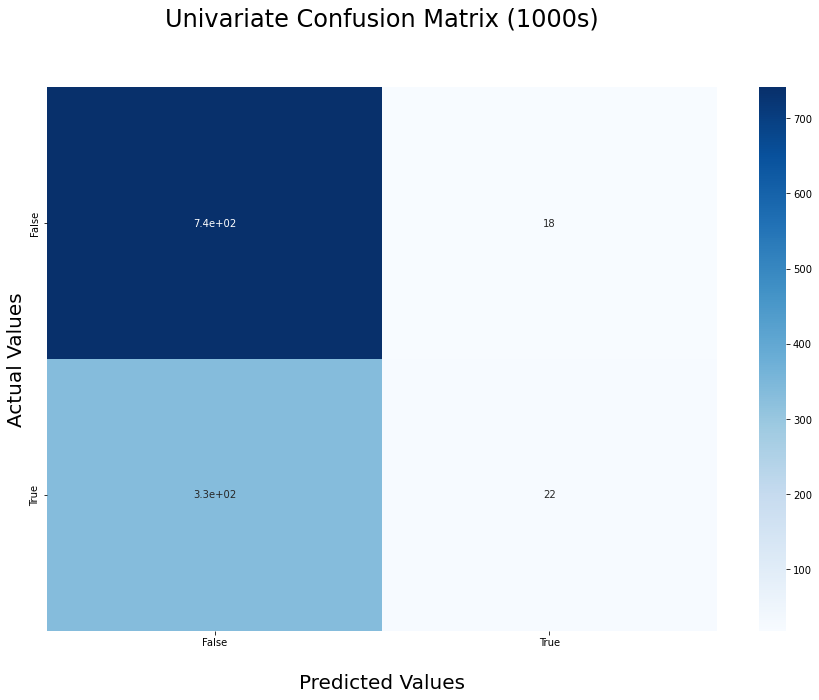

<Figure size 1080x720 with 0 Axes>

In [22]:
import seaborn as sns

ax = sns.heatmap(cm1/1000, annot=True, cmap='Blues')

ax.set_title('Univariate Confusion Matrix (1000s)\n\n', fontsize=24);
ax.set_xlabel('\nPredicted Values', size=20)
ax.set_ylabel('Actual Values', size=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()
plt.savefig('CM1')

## The sensitivity only catches 6% of true positives. That's not very helpful predictive ability. Let's see if we can look back into that linear relationship rather than classifying.

In [23]:
##at each level of BMI, find the % of women that undergo a C-section
X_means = [bmi_csec.loc[x]['percent'] for x in X_test['BMI'].unique()]

(-0.1, 1.1)

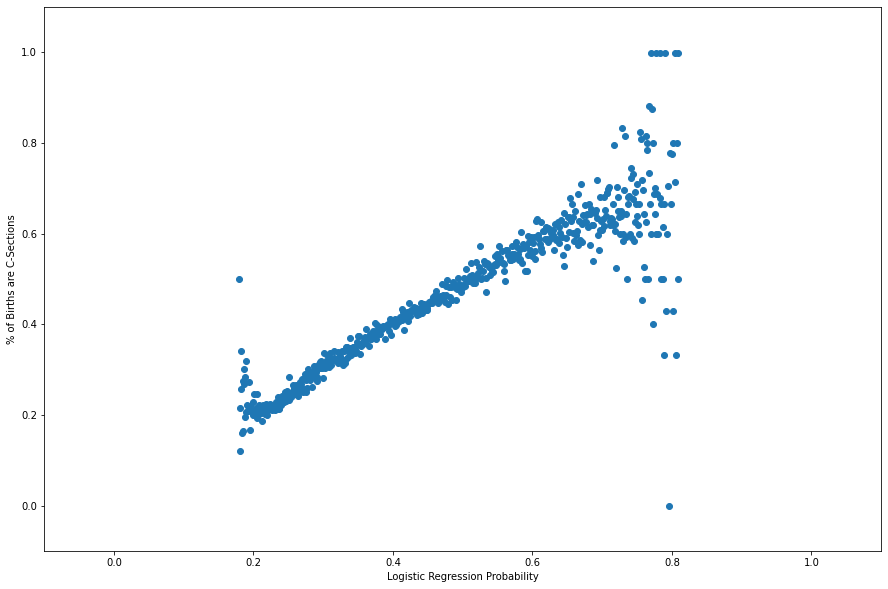

In [24]:
###graph of the logistic regression probability outputs at each BMI against the % C-sections of that BMI

logprobs = model.predict_proba(X_test.drop_duplicates(subset='BMI'))
plt.scatter(logprobs[:,1], X_means)
plt.xlabel('Logistic Regression Probability')
plt.ylabel('% of Births are C-Sections')
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)

In [25]:
lmlogmodel = sm.OLS(logprobs[:,1],X_means)
lmlogresult = lmlogmodel.fit()
print(lmlogresult.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.978
Model:                            OLS   Adj. R-squared (uncentered):              0.978
Method:                 Least Squares   F-statistic:                          2.442e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                        0.00
Time:                        10:56:08   Log-Likelihood:                          631.47
No. Observations:                 558   AIC:                                     -1261.
Df Residuals:                     557   BIC:                                     -1257.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### The model predicts the probability of a c-section really well with just BMI as a variable, but does not classify well. Let's try more variables to get outside of the linear BMI predictor and see if we can classify better.

# Logistic Regression Classification With More Variables

In [26]:
#relabel unknown values as NaN
known_births['DOB_TT'][known_births['DOB_TT'] == 9999] = np.nan
known_births['DWgt_R'][known_births['DWgt_R'] == 999] = np.nan
known_births['FAGECOMB'][known_births['FAGECOMB'] == 99] = np.nan
known_births['ILLB_R'][known_births['ILLB_R'] == 999] = np.nan
known_births['ILLB_R'][known_births['ILLB_R'] == 888] = np.nan
known_births['ILOP_R'][known_births['ILOP_R'] == 999] = np.nan
known_births['ILOP_R'][known_births['ILOP_R'] == 888] = np.nan
known_births['ILP_R'][known_births['ILOP_R'] == 999] = np.nan
known_births['ILP_R'][known_births['ILOP_R'] == 888] = np.nan
known_births['M_Ht_In'][known_births['M_Ht_In'] == 99] = np.nan
known_births['PREVIS'][known_births['PREVIS'] == 99] = np.nan
known_births['PRIORLIVE'][known_births['PRIORLIVE'] == 99] = np.nan
known_births['PRIORTERM'][known_births['PRIORTERM'] == 99] = np.nan
known_births['PWgt_R'][known_births['PWgt_R'] == 999] = np.nan
known_births['WTGAIN'][known_births['WTGAIN'] == 99] = np.nan

C:\Users\Rukh\AppData\Local\Temp\ipykernel_24864\4168427906.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  known_births['DOB_TT'][known_births['DOB_TT'] == 9999] = np.nan
C:\Users\Rukh\AppData\Local\Temp\ipykernel_24864\4168427906.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  known_births['DWgt_R'][known_births['DWgt_R'] == 999] = np.nan
C:\Users\Rukh\AppData\Local\Temp\ipykernel_24864\4168427906.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [27]:
formula = 'C_SECTION ~ 0 + C(ATTEND) + C(DMAR) + C(DOB_MM) + C(DOB_WK) + C(FEDUC) + C(FHISPX) + C(FRACE15) + C(LD_INDL) + C(MEDUC) + C(MHISPX) + C(MRACE15) + C(NO_RISKS) + C(PAY_REC) + C(PRECARE) + BMI + DOB_TT + DWgt_R + FAGECOMB + ILLB_R + ILOP_R + ILP_R + M_Ht_In + MAGER + PREVIS + PRIORLIVE + PRIORTERM + PWgt_R + C(WTGAIN)'
y, X = dmatrices(formula, known_births, return_type='dataframe')

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model = LogisticRegression()
result = model.fit(X_train, y_train)

c:\Users\Rukh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Rukh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
y_pred = model.predict(X_test)
print('Acc {}'.format(metrics.accuracy_score(y_test, y_pred)))
print('Precision {}'.format(metrics.precision_score(y_test, y_pred)))
print('Recall {}'.format(metrics.recall_score(y_test, y_pred)))
print('F-Score {}'.format(metrics.f1_score(y_test, y_pred)))

Acc 0.6924251197557509
Precision 0.6360708534621579
Recall 0.18661417322834645
F-Score 0.2885669061244368


In [30]:
cm2 = metrics.confusion_matrix(y_test, y_pred)
print(cm2)
sensitivity = cm2[1,1]/sum(cm2[1])
print('Sensitivity {}'.format(sensitivity))

[[71814  4068]
 [30990  7110]]
Sensitivity 0.18661417322834645


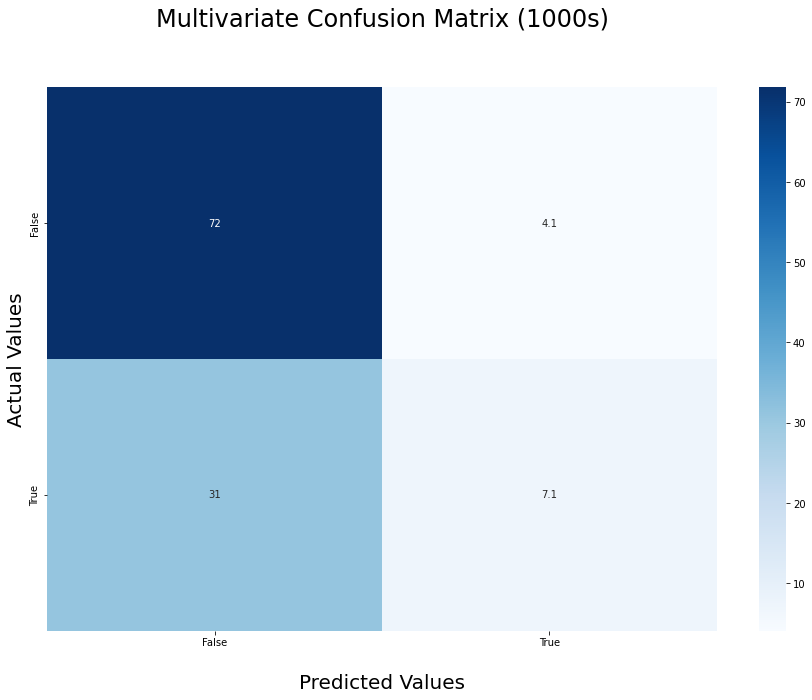

In [31]:
ax = sns.heatmap(cm2/1000, annot=True, cmap='Blues')

ax.set_title('Multivariate Confusion Matrix (1000s)\n\n', fontsize=24);
ax.set_xlabel('\nPredicted Values', size=20)
ax.set_ylabel('Actual Values', size=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [32]:
logweights = DataFrame(data={'Coefficient':model.coef_[0]}, index=X.columns)
logweights.sort_values(by='Coefficient', ascending=False)

,Coefficient
BMI,0.084894
MAGER,0.072248
C(ATTEND)[1],0.058588
PREVIS,0.023153
C(DOB_WK)[T.2],0.014133
...,...
M_Ht_In,-0.045708
C(ATTEND)[3],-0.050591
PRIORLIVE,-0.087071
C(LD_INDL)[T.Y],-0.105645


Let's dive deeper into the linear regression.

# Linear Regression

In [33]:
model = sm.OLS(vis['percent'],vis['BMI'])
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                percent   R-squared (uncentered):                   0.967
Model:                            OLS   Adj. R-squared (uncentered):              0.967
Method:                 Least Squares   F-statistic:                          1.637e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                        0.00
Time:                        11:00:29   Log-Likelihood:                          552.74
No. Observations:                 566   AIC:                                     -1103.
Df Residuals:                     565   BIC:                                     -1099.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## There's an Adj. R-squared of 0.967 with just BMI! It's a great predictor of likelihood of C-section at an almost perfectly linear relationship with slope of 1 and no intercept. Unless at the extremes of underweight and beyond morbidly obese, a woman's BMI before pregnancy is roughly the % likelihood that she'll deliver via C-Section.

# Dividing BMI into Categorical Variables

In [34]:
# underweight = (known_births['BMI'] < 18.5)
# normal_weight = (known_births['BMI'] >= 18.5) & (known_births['BMI'] < 25)
# overweight = (known_births['BMI'] >= 25) & (known_births['BMI'] < 30)
# obese = (known_births['BMI'] >= 30) & (known_births['BMI'] < 40)
# morbidly_obese = (known_births['BMI'] >= 40) & (known_births['BMI'] < 50)
# extreme = (known_births['BMI'] >= 50)

In [35]:
# known_births['BMI2'] = np.nan
# known_births['BMI2'][underweight] = 'underweight'
# known_births['BMI2'][normal_weight] = 'normal weight'
# known_births['BMI2'][overweight] = 'overweight'
# known_births['BMI2'][obese] = 'obese'
# known_births['BMI2'][morbidly_obese] = 'morbidly obese'
# known_births['BMI2'][extreme] = 'extreme'

In [36]:
# vis2.to_csv('vis2.csv')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


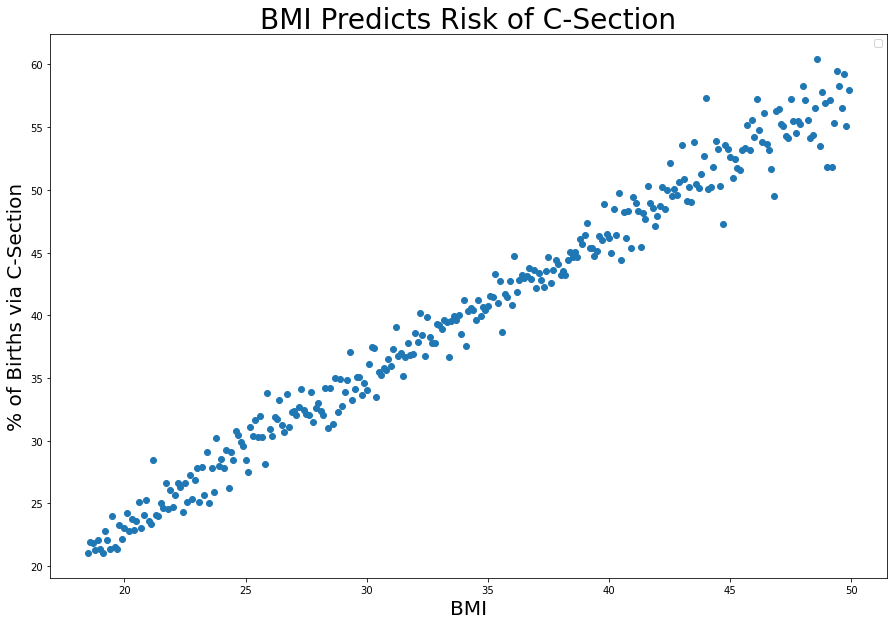

In [37]:
bmi_mask = (vis['BMI'] >= 18.5) & (vis['BMI'] < 50)
vis2 = vis[bmi_mask]

plt.scatter(vis2['BMI'],vis2['percent']*100)
plt.xlabel('BMI', size=20)
plt.ylabel('% of Births via C-Section', size=20)
plt.title('BMI Predicts Risk of C-Section', size = 28)

# plt.plot(vis2['BMI'], lm_pred, color='red', linewidth=5, label='Regression')
plt.legend(loc='best')

plt.savefig('LMBMIVRATE2')

In [38]:
###### SKLEARN linear regression (vis2 - remove extreme BMI)
model = LinearRegression()
result = model.fit(vis2['BMI'].values.reshape(-1,1)*100,vis2['percent'].values.reshape(-1,1))
print(result.intercept_)
print(result.coef_)
#####

[0.00384543]
[[0.00011565]]


In [39]:
####stats model linear regression (vis2 - remove extreme BMI) -- seems to remove intercept and roll into beta
model = sm.OLS(vis2['percent']*100,vis2['BMI'])
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                percent   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          2.588e+05
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                        0.00
Time:                        11:00:30   Log-Likelihood:                         -561.50
No. Observations:                 315   AIC:                                      1125.
Df Residuals:                     314   BIC:                                      1129.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [40]:
lm_pred = result.params['BMI']*vis2['BMI']

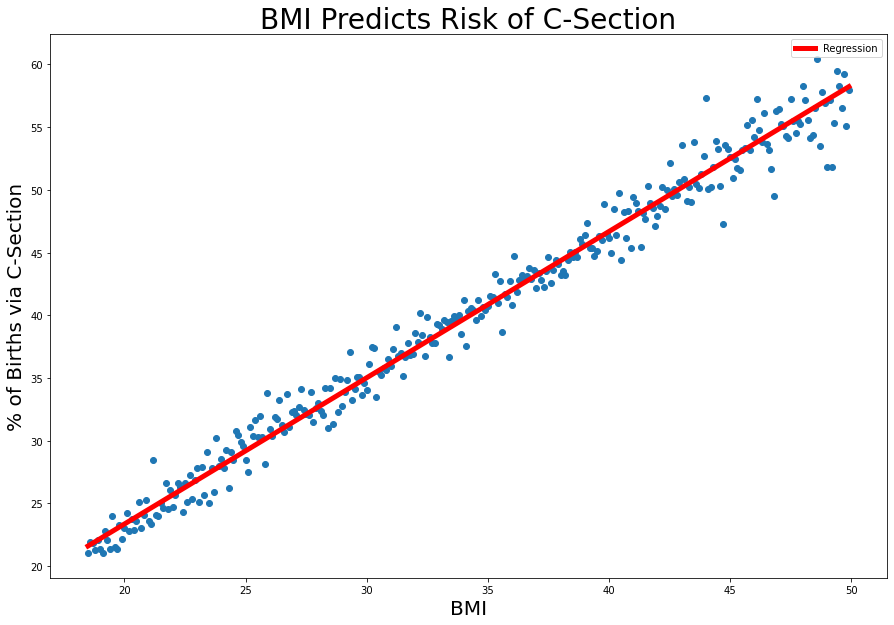

In [41]:
bmi_mask = (vis['BMI'] >= 18.5) & (vis['BMI'] < 50)
vis2 = vis[bmi_mask]

plt.scatter(vis2['BMI'],vis2['percent']*100)
plt.xlabel('BMI', size=20)
plt.ylabel('% of Births via C-Section', size=20)
plt.title('BMI Predicts Risk of C-Section', size = 28)

plt.plot(vis2['BMI'], lm_pred, color='red', linewidth=5, label='Regression')
plt.legend(loc='best')

plt.savefig('LMBMIVRATE2')